# A/B тестирование: тест пропорций

#### Постановка задачи

Продуктовая команда предложила новый дизайн кнопки перехода к оплате товара. Необходимо протестировать, влияет ли новый дизайн на увеличение конверсии. Текущее значение конверсии составляет 12%. Ожидаемый эффект от внедрения нового дизайна - увеличение конверсии на 2%.

#### Формулирование гипотез

Нулевая гипотеза: новый дизайн не влияет на конверсию. 
Альтернативная гипотеза: новый дизайн увеличивает конверсию (односторонняя гипотеза).
Уровень значимости = 0.05.

#### Дизайн эксперимента

Необходимо разделить участников эксперимента на две группы:
1. Контрольная группа (control) - им будет показан старый дизайн.
2. Экспериментальная группа (treatment)  - им будет показан новый дизайн.

#### Определение размера выборки

Согласно сформулированному заданию, размер эффекта составляет 2%, т.е. конверсия должна увеличиться с 12 хотя бы до 14%. Установим мощность теста на уровне 80% и рассчитаем необходимый размер выборки.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import zt_ind_solve_power
import warnings
warnings.filterwarnings('ignore')

effect_size = sms.proportion_effectsize(0.12, 0.14) 
required_n = sms.NormalIndPower().solve_power(effect_size, 
                                              power=0.8, 
                                              alpha=0.05, 
                                              ratio=1,
                                              alternative='smaller')                                                                       

print(f'Необходимый размер выборки составляет {ceil(required_n)} чел.')

Необходимый размер выборки составляет 3492 чел.


Итак, для проведения эксперимента нам необходимо, по крайней мере, 3492 человека в каждой из групп.

#### Сбор и обработка данных

In [2]:
# загрузка данных

data = pd.read_csv('test_data.csv')
data.head()

,user_id,timestamp,group,button_design,converted
0,340198,2021-12-01 00:04:01,control,old,False
1,816458,2021-12-01 00:09:50,control,old,True
2,598083,2021-12-01 00:25:28,treatment,new,False
3,459305,2021-12-01 00:28:32,control,old,False
4,989656,2021-12-01 00:35:11,treatment,new,False


In [3]:
# проверка отсутствующих значений

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        8950 non-null   int64 
 1   timestamp      8950 non-null   object
 2   group          8950 non-null   object
 3   button_design  8950 non-null   object
 4   converted      8950 non-null   bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 183.6+ KB


In [4]:
# проверка, участвовал ли один и тот же человек в эксперименте более одного раза.

len(data['user_id'].unique()) == data.shape[0]

False

In [5]:
len(data['user_id'].unique())

8904

В выборке есть пользователи, которые принимали участие в эксперименте более одного раза. Если пользователь принадлежит одной и той же группе, и его действие не поменялось, то удалим повторяющуюся строку. Если пользователь был включен в разные группы, или его действие изменилось, то исключим этого пользователя из выборки.

In [6]:
duplicates = data[data.duplicated('user_id', keep=False)]
duplicates.drop_duplicates(subset=['user_id', 'group', 'button_design', 'converted'], inplace=True)
data.drop(duplicates.index, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8875 entries, 0 to 8949
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        8875 non-null   int64 
 1   timestamp      8875 non-null   object
 2   group          8875 non-null   object
 3   button_design  8875 non-null   object
 4   converted      8875 non-null   bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 251.3+ KB


In [7]:
# рассчитаем конверсию в группах

test_results = data.groupby('group', as_index=False).agg({'user_id': 'count',
                                                  'converted': 'sum'}) \
                                                        .rename(columns={'user_id': 'total'})
test_results['conversion, %'] = round(test_results['converted'] / test_results['total'] * 100, 2)
test_results['converted'] = test_results['converted'].astype(int)
test_results

,group,total,converted,"conversion, %"
0,control,4441,514,11.57
1,treatment,4434,551,12.43


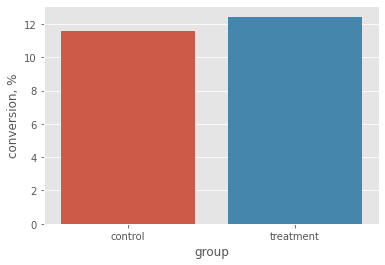

In [8]:
plt.style.use('ggplot')
sns.barplot(x=test_results['group'], y=test_results['conversion, %'])
plt.show()

В каждой из групп количество наблюдений превышает минимально допустимый объем выборки, можно перейти к проверке гипотезы.

#### Проверка гипотезы

Для проверки гипотезы воспользуемся тестом пропорций.

In [9]:
successes = [test_results.iloc[0, 2], test_results.iloc[1, 2]]
n_obs = [test_results.iloc[0, 1], test_results.iloc[1, 1]]

z_stat, pval = proportions_ztest(successes, n_obs, alternative='smaller')
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, n_obs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ДИ 95% для контрольной группы: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ДИ 95% для экспериментальной группы: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.24
p-value: 0.108
ДИ 95% для контрольной группы: [0.106, 0.125]
ДИ 95% для экспериментальной группы: [0.115, 0.134]


#### Вывод

Найденное значение p-value превышает уровень значимости 0.05, следовательно новый дизайн не приводит к статистически значимому увеличению конверсии.